# Homework 8

## Heading Symbols: 

(*) - Plotting Code.

(**) - Utility/Configuration Code.

# Importing Modules *

In [4]:
from collections.abc import Sequence
import os # WARN: Might remove latter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import geopandas as gpd
from cartogram import Cartogram

# Part 1: Choropleths

## Importing Data **

In [5]:
tariff_data = pd.read_csv("./state_tariff.csv", header=0)
albers_us_map = gpd.read_file("./us_albers/us_albers.shp")
tax_choropleth_data = pd.merge(albers_us_map, tariff_data, on="NAME", how="left")

## Defining Annotations **

In [20]:
title: str = "Estimated impact of Trump tariffs on Imports from Canada, China" \
    + " and Mexico"

money_rule: tuple[str, str, str] = (
    r"< {:.2f}",
    r"> {:.2f}",
    r"{:.2f} ~ {:.2f}",
)

def generate_bin_labels(bins: Sequence[int|float],
                        rule: tuple[str, str,str]) -> list[str]:
    bin_labels = []
    for index in range(len(bins)):
        match index:
            case 0:
                bin_labels.append(rule[0].format(bins[index]))
            case _ if index == len(bins) - 1:
                bin_labels.append(rule[1].format(bins[index]))
            case _:
                bin_labels.append(rule[2].format(
                    bins[index-1], bins[index]))
    return bin_labels

## Choropleth with specified bins *

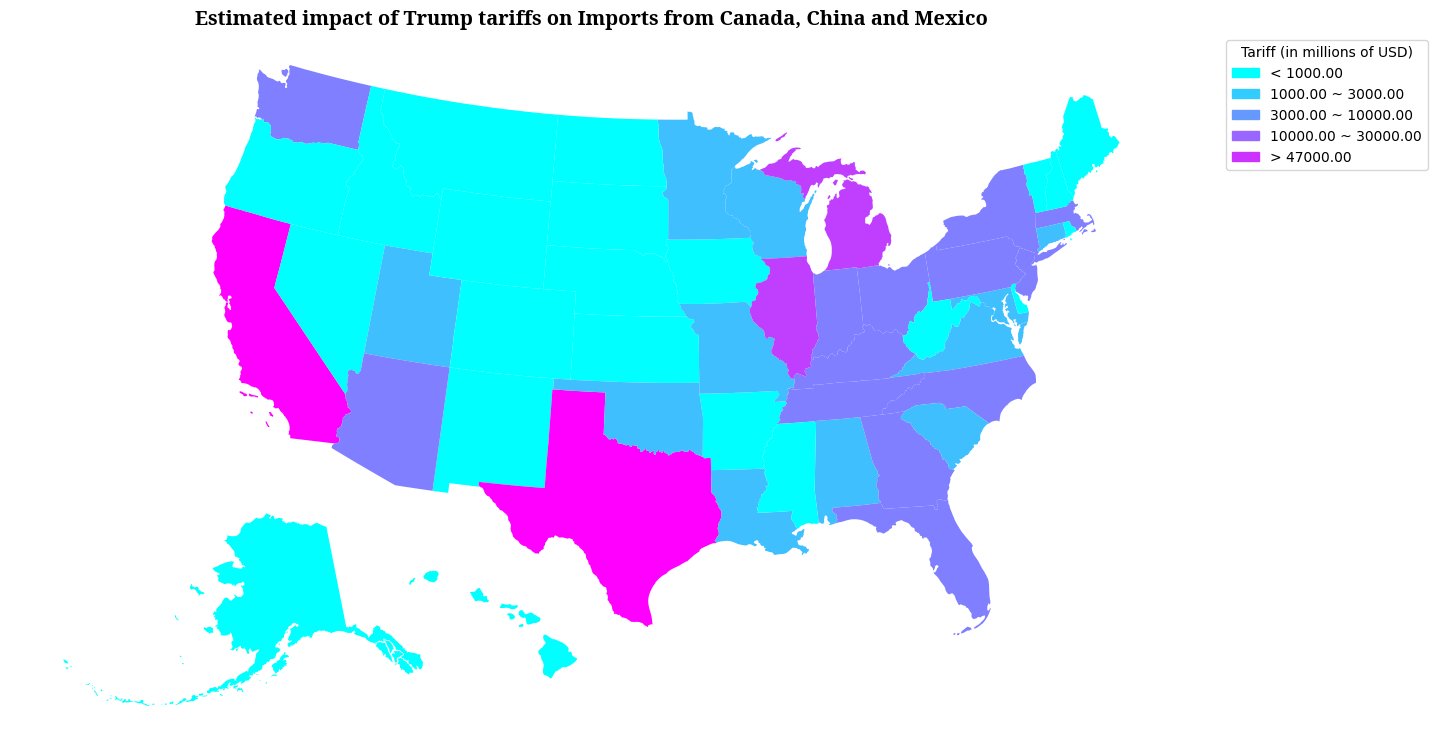

In [21]:
# NOTE: Generate bins
bins = (1_000, 3_000, 10_000, 30_000, 47_000)
bin_labels = generate_bin_labels(bins, money_rule)
handles = [mpatches.Patch(color=plt.cm.cool(i / len(bins)), label=label)
       for i, label in enumerate(bin_labels)]

# NOTE: Generate plot
fig, ax = plt.subplots(figsize=(15,12))
tax_choropleth_data.plot(
    column="tariff", legend=True, ax=ax,
    cmap="cool", scheme="User_Defined",
    classification_kwds=dict(bins=bins)
)

# NOTE: Prettify plot
# TODO: Add annotations?
ax.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc='upper left', title='Tariff (in millions of USD)') 
ax.set_axis_off()
ax.set_title(title, weight="bold", size="x-large", fontname="Noto Serif")
plt.show()

## Choropleth split by data quantiles *

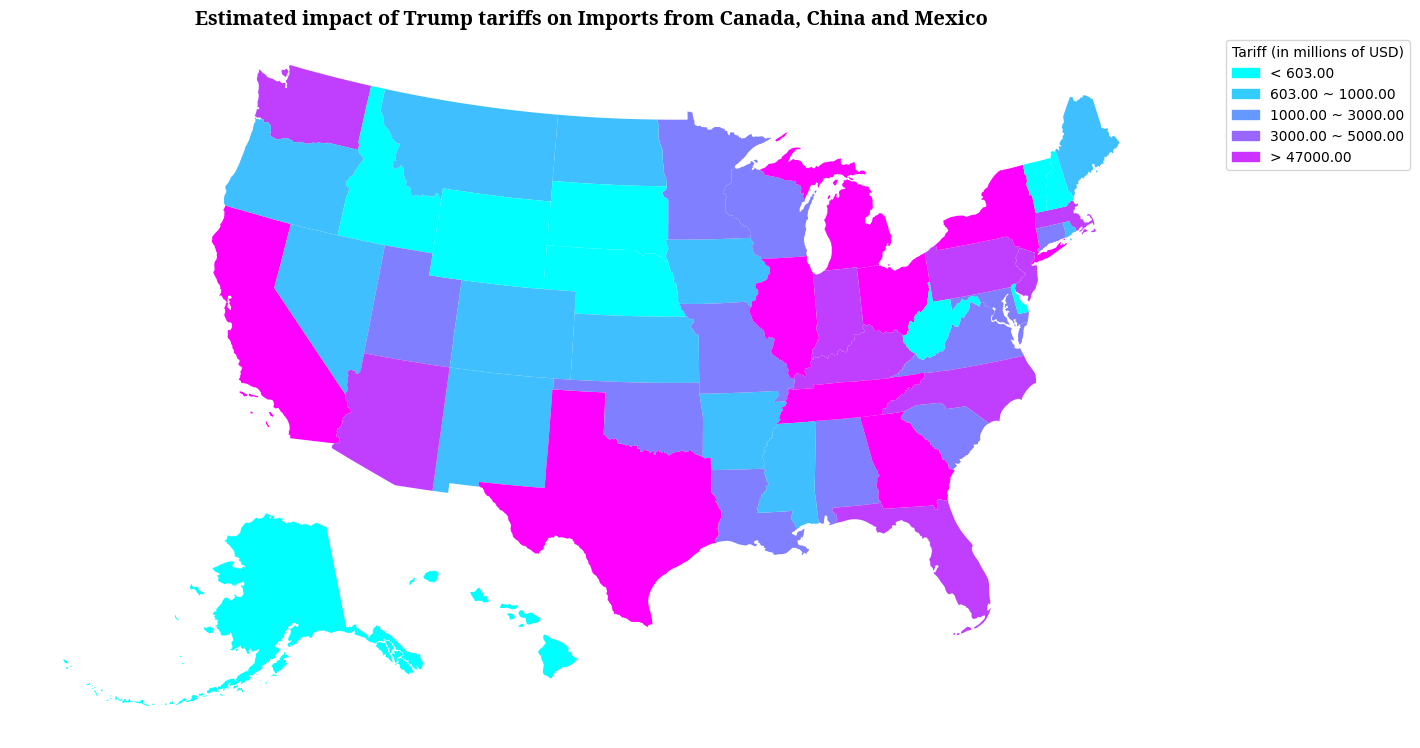

In [22]:
# NOTE: Generate bins
bins = tuple(
    tax_choropleth_data.sort_values("tariff").iloc[i].tariff
        for i in range(9,50,10)
)
bin_labels = generate_bin_labels(bins, money_rule)
handles = [mpatches.Patch(color=plt.cm.cool(i / len(bins)), label=label)
           for i, label in enumerate(bin_labels)]

# NOTE: Generate plot
fig, ax = plt.subplots(figsize=(15,12))
tax_choropleth_data.plot(
    column="tariff", legend=True, ax=ax,
    cmap="cool", scheme="User_Defined",
    classification_kwds=dict(bins=bins)
)
# NOTE: Prettify plot
# TODO: Add annotations?
ax.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc='upper left', title='Tariff (in millions of USD)')
ax.set_axis_off()
ax.set_title(title, weight="bold", size="x-large", fontname="Noto Serif")
plt.show()

# Part 2: Cartograms
## Contiguous

## Import data **
Sometimes, geospatial data can be big, and requires extra time to merge the economic and geospatial dataframes. The next code block creates a file that stores the merged dataframe in disk and reuses it.

In [15]:
try:
    open("cartogram_population/cartogram_albers.shp")
except FileNotFoundError:
    print("Cartograms not found. Creating data...")
    population_data = pd.read_csv("./2024_state_pops.csv", header=0, index_col=0)
    us_cartogram = pd.merge(
        tax_choropleth_data, population_data,
        on="NAME", how="left"
    )
    us_cartogram.dropna(inplace=True)
    us_cartogram["pop_tariff"] = \
        us_cartogram.tariff / us_cartogram.Population # NOTE: Total tariff over state population
    us_cartogram = Cartogram(us_cartogram, "pop_tariff") 

    if 'cartogram_population' not in os.listdir():
        os.mkdir("cartogram_population")

    us_cartogram.to_file("cartogram_population/cartogram_albers.shp")

    # Create the colormap
    reds = mcolors.LinearSegmentedColormap.from_list("Reds", colors)
    
    colors = []
    for i in range(len(gdf_merged)):
        total = gdf_merged["Percent (R)"].iloc[i] + gdf_merged["Percent (D)"].iloc[i]
        ratio = gdf_merged["Percent (D)"].iloc[i] / total
        colors.append(red_purple_blue(ratio))
    gdf_merged["purples"] = colors
finally:
    us_cartogram = gpd.read_file("cartogram_population/cartogram_albers.shp")

# Data Annotations **

In [16]:
ratio_rule: tuple[str, str, str] = (
    r"< {:.3%}",
    r"> {:.3%}",
    r"{:.3%} ~ {:.3%}",
)

## Contiguous Cartogram *

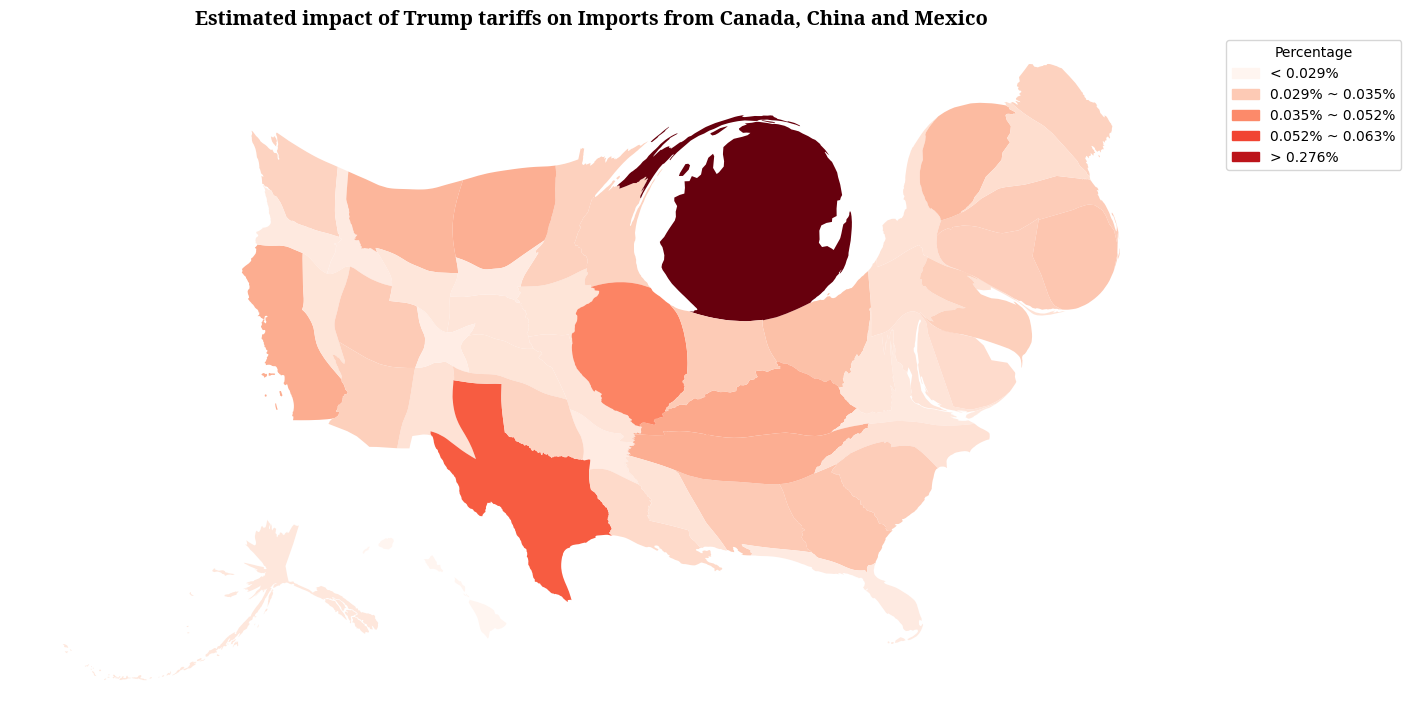

In [19]:
bins = tuple(
    us_cartogram.sort_values("pop_tariff").iloc[i].pop_tariff for i in range(9,50,10)
)
bin_labels = generate_bin_labels(bins, ratio_rule)
handles = [mpatches.Patch(color=plt.cm.Reds(i / len(bins)), label=label)
           for i, label in enumerate(bin_labels)]

# NOTE: Generate Plot
fig, ax = plt.subplots(figsize=(15,12))
us_cartogram.plot(column="pop_tariff", cmap="Reds", ax=ax
                  # scheme="User_Defined", classification_kwds=dict(bins=bins)
)
ax.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc='upper left', title='Percentage')
ax.set_axis_off()
ax.set_title(title, weight="bold", size="x-large", fontname="Noto Serif")
plt.show()

## Tile Grid Cartogram

## Import Data **

In [56]:
try:
    open("cartogram_change/cartogram_albers.shp")
except FileNotFoundError:
    print("Cartograms not found. Creating data...")
    us_cartogram_change = tax_choropleth_data.dropna()
    us_cartogram_change["original"] = \
        us_cartogram_change.tariff * 100/(100 + us_cartogram_change.cpg) 
    us_cartogram_change = Cartogram(us_cartogram_change, "cpg") 

    if 'cartogram_data' not in os.listdir():
        os.mkdir("cartogram_change")

    us_cartogram_change.to_file("cartogram_change/cartogram_albers.shp")
finally:
    us_cartogram_change = gpd.read_file("cartogram_change/cartogram_albers.shp")

## Plotting

For this part, I decided to follow the original suggestion of adding linecharts to the tiles, but it didn't work very well. I ended up using the gradient approach.

Even then, the next code block is tilegrids with embedded linecharts.

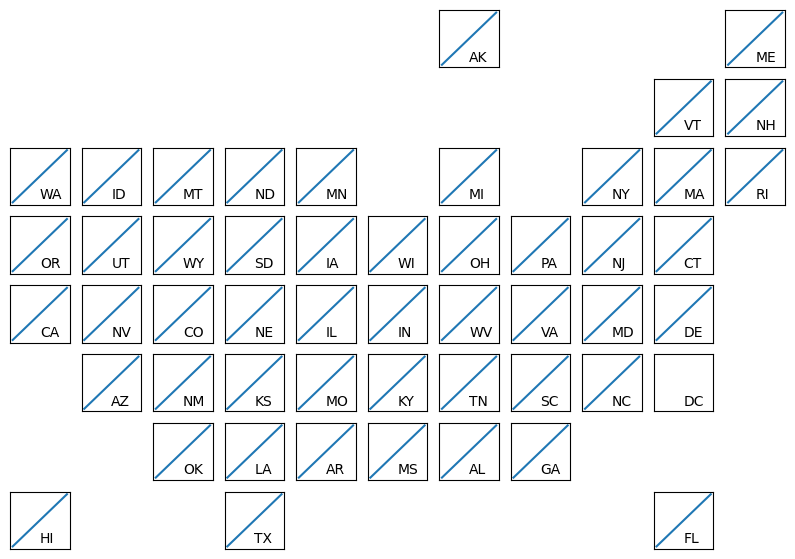

In [58]:
# Create a figure with 8x11 axes
nrows, ncols = 8, 11
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(10, 7))
# define positions of rows that we want off
rows_to_remove = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5),        (0,7), (0,8), (0,9), 
                  (1,0), (1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), 
                                                     (2,5),        (2,7), 
                                                                                        (3,10), 
                                                                                        (4,10), 
                  (5,0),                                                                (5,10), 
                  (6,0), (6,1),                                           (6,8), (6,9), (6,10), 
                         (7,1), (7,2),        (7,4), (7,5), (7,6), (7,7), (7,8),        (7,10)]
# define first letters of each state
letters_state = ['AK', 'ME', 'VT', 'NH', 'WA', 'ID', 'MT', 'ND', 'MN', 'MI', 'NY',
                 'MA', 'RI', 'OR', 'UT', 'WY', 'SD', 'IA', 'WI', 'OH', 'PA',
                 'NJ', 'CT', 'CA', 'NV', 'CO', 'NE', 'IL', 'IN', 'WV', 'VA',
                 'MD', 'DE', 'AZ', 'NM', 'KS', 'MO', 'KY', 'TN', 'SC', 'NC',
                 'DC', 'OK', 'LA', 'AR', 'MS', 'AL', 'GA', 'HI', 'TX', 'FL']

# Define axis limits
y_bot, y_top = us_cartogram_change.original.min(), us_cartogram_change.tariff.max()

# Iteare over each ax
state = 0
for row in range(nrows):
    for col in range(ncols):
        
        # test the presence of the current ax in the list defined above
        if (row, col) in rows_to_remove:
            axs[row, col].axis('off')
        
        # all axes we want to keep
        else:
            
            # Remove axis labels
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            
            # add state's letters
            letters = letters_state[state]
            axs[row, col].annotate(letters, xy=(0.5, 0.1),
                                   xycoords='axes fraction', color="black")
            
            # Linechart
            axs[row, col].plot(
                us_cartogram_change.loc[us_cartogram.STUSPS == letters, ["original", "tariff"]].T
            )
            ax.set_ylim(0, 500_000)            
            
            state += 1

Here is the gradient tilegrid:

In [ ]:
# Create a figure with 8x11 axes
nrows, ncols = 8, 11
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(10, 7))
# define positions of rows that we want off
rows_to_remove = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5),        (0,7), (0,8), (0,9), 
                  (1,0), (1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), 
                                                     (2,5),        (2,7), 
                                                                                        (3,10), 
                                                                                        (4,10), 
                  (5,0),                                                                (5,10), 
                  (6,0), (6,1),                                           (6,8), (6,9), (6,10), 
                         (7,1), (7,2),        (7,4), (7,5), (7,6), (7,7), (7,8),        (7,10)]
# define first letters of each state
letters_state = ['AK', 'ME', 'VT', 'NH', 'WA', 'ID', 'MT', 'ND', 'MN', 'MI', 'NY',
                 'MA', 'RI', 'OR', 'UT', 'WY', 'SD', 'IA', 'WI', 'OH', 'PA',
                 'NJ', 'CT', 'CA', 'NV', 'CO', 'NE', 'IL', 'IN', 'WV', 'VA',
                 'MD', 'DE', 'AZ', 'NM', 'KS', 'MO', 'KY', 'TN', 'SC', 'NC',
                 'DC', 'OK', 'LA', 'AR', 'MS', 'AL', 'GA', 'HI', 'TX', 'FL']

# Define axis limits
y_bot, y_top = us_cartogram_change.original.min(), us_cartogram_change.tariff.max()

# Iteare over each ax
state = 0
for row in range(nrows):
    for col in range(ncols):
        
        # test the presence of the current ax in the list defined above
        if (row, col) in rows_to_remove:
            axs[row, col].axis('off')
        
        # all axes we want to keep
        else:
            
            # Remove axis labels
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            
            # add state's letters
            letters = letters_state[state]
            axs[row, col].annotate(letters, xy=(0.5, 0.1),
                                   xycoords='axes fraction', color="black")
            
            # Add color
            axs[row, col].set_facecolor(gdf_merged[gdf_merged["STUSPS"] == letters]["purples"].iloc[0])

            state += 1